# Algorithms

Study and comparison of different techniques and clustering algorithms.

In [5]:
# Libraries
import pandas as pd
import numpy as np
import json

from pickle import dump #  To save and read binaries of models and scalers 

# for K approximations:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans

from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# DBSCAN:
from sklearn.cluster import DBSCAN

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
df_movies = pd.read_json('Data/datasets/vectorized/movies_vectorized_25.json', orient='records')

# Content-based approach

## KMeans

### Rudimentary KMeans

In [3]:
km_movies_basic = KMeans(n_clusters=15, random_state=0)

In [4]:
km_movies_basic.fit(df_movies)

KMeans(n_clusters=15, random_state=0)

### KMeans with K approximation

Different methods that the literature suggest will be used.


#### Elbow Method 

A more rudimentary method, [explanation]...

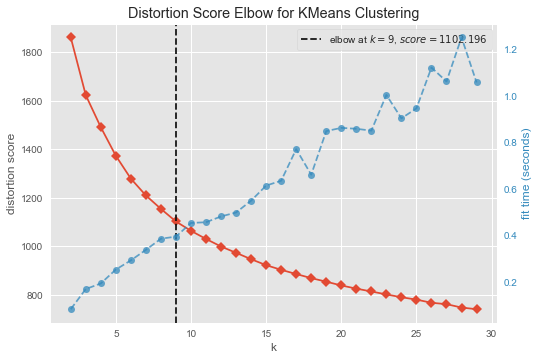

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
model_1 = KMeans(
    n_init = 20,
    algorithm = 'elkan',
)
visualizer = KElbowVisualizer(
    model_1,
    k=(2,30),                       # k is range of number of clusters.
    timings= True
    )

visualizer.fit(df_movies)                   # Fit data to visualizer
visualizer.show()                   # Finalize and render the figure

#### Silhouette score method

Calculates the mean Silhouette Coefficient of all samples.

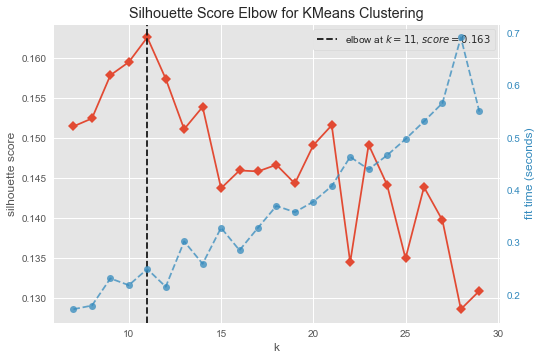

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [24]:
model_2 = KMeans()

visualizer = KElbowVisualizer(
    model_2,
    k=(7,30),                   # k is range of number of clusters.
    metric = 'silhouette',      # 2nd method to approximate K.
    timings=True
    )

visualizer.fit(df_movies)       # Fit the data to the visualizer
visualizer.show()               # Finalize and render the figure

In [25]:
visualizer.elbow_value_

11

#### Calinski Harabasz method

Computes the ratio of dispersion between and within clusters

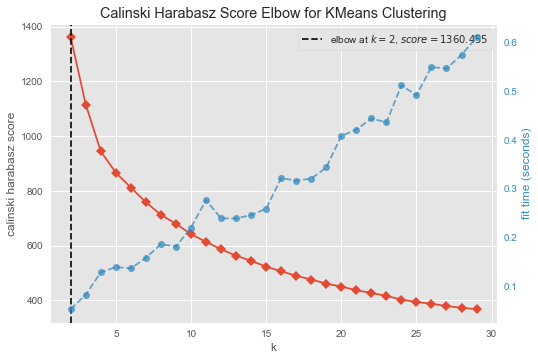

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [8]:
model_3 = KMeans()

visualizer = KElbowVisualizer(
    model_3,
    k=(2,30),                           # k is range of number of clusters.
    metric = 'calinski_harabasz',       # 3rd method to approximate K.
    timings=True
    )

visualizer.fit(df_movies)               # Fit the data to the visualizer
visualizer.show()               # Finalize and render the figure


## DBSCAN

In [172]:
model = DBSCAN(eps=0.5, min_samples=60)

l  = model.fit_predict(df_movies)

metrics.silhouette_score(df_movies, l)


0.23315372534932124

## Benchmarking

In [21]:
import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [33]:
df_movies = pd.read_json('Data/datasets/vectorized/movies_vectorized_25.json', orient='records')

### KMeans

In [34]:
# Define dataframe:
df_kmeans_movies = pd.DataFrame(
    columns = [
        'Initialization',           # K-means++ or random.
        'K-approximation method',   # Elbow or silhouette.
        'Number of clusters',       # Number of clusters suggested by the approximation method.
        'Inertia',                  # Or within-cluster sum-of-squares. The lower, the better.
        'Silhouette score',         # Instrinsic method to evaluate quality of cluster. 
        'Fit time'
    ]
)

In [35]:
# Function to obtain K approximation.

def calculate_elbow(model, data):
    visualizer = KElbowVisualizer(
        model,
        k=(2,30),                   # k is range of number of clusters.
        timings=True
    )

    visualizer.fit(data)            # Fit the data to the visualizer

    return visualizer.elbow_value_

def calculate_silhouette(model, data):
    visualizer = KElbowVisualizer(
        model,
        k=(7,30),                   # k is range of number of clusters.
        metric = 'silhouette',      # 2nd method to approximate K.
        timings=True
    )

    visualizer.fit(data)            # Fit the data to the visualizer

    return visualizer.elbow_value_

In [36]:
# Define benckmarking function for KMeans

def benchmark_k_means(model, data):
    """
    Benchmark to evaluate KMeans initialization methods.

    Parameters
    ----------
    model : KMeans instance
    data : data to cluster.

    Returns
    -------
    results : dictionary with structure
        {
            'fit_time' : ,
            'inertia' : ,
            'silhouette'
        }

    """
    t0 = time.time()
    estimator = make_pipeline(StandardScaler(), model).fit(data)
    fit_time = time.time() - t0

    results = {}
    results['Fit time'] = fit_time
    results['Inertia'] = estimator[-1].inertia_

    # The silhouette score requires the full dataset
    results['Silhouette score'] = metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
            )

    return results

#### K-means++

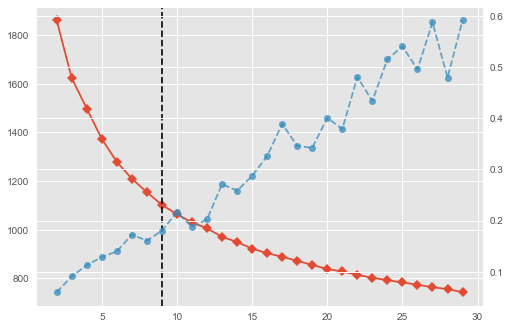

In [37]:
# We'll start with k-means++ initialization method (default method)
model = KMeans(
    init='k-means++',
    algorithm='elkan'
)

model.n_clusters = calculate_elbow(model, df_movies)

d = {
    'Initialization' : model.init,
    'K-approximation method' : 'elbow',
    'Number of clusters' : model.n_clusters
}

results = {**d, **benchmark_k_means(model, df_movies) } # Merges the 2 dictionaries.

df_kmeans_movies = df_kmeans_movies.append(results, ignore_index=True)

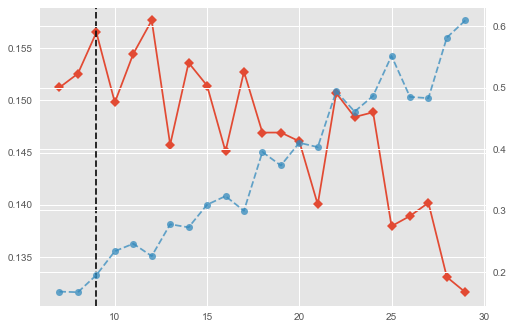

In [38]:
# We'll start with k-means++ initialization method (default method)
model = KMeans(
    init='k-means++',
    algorithm='elkan'
)

model.n_clusters = calculate_silhouette(model, df_movies)

d = {
    'Initialization' : model.init,
    'K-approximation method' : 'silhouette',
    'Number of clusters' : model.n_clusters
}

results = {**d, **benchmark_k_means(model, df_movies) } # Merges the 2 dictionaries.

df_kmeans_movies = df_kmeans_movies.append(results, ignore_index=True)

#### Random

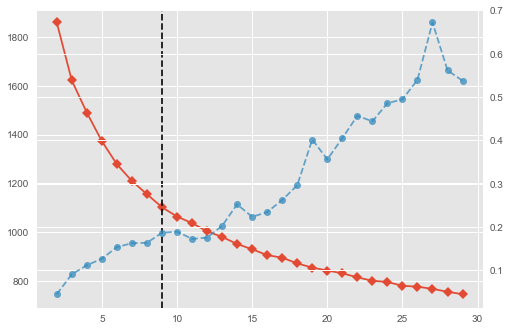

In [39]:
# We'll start with k-means++ initialization method (default method)
model = KMeans(
    init='random',
    algorithm='elkan'
)

model.n_clusters = calculate_elbow(model, df_movies)

d = {
    'Initialization' : model.init,
    'K-approximation method' : 'elbow',
    'Number of clusters' : model.n_clusters
}

results = {**d, **benchmark_k_means(model, df_movies) } # Merges the 2 dictionaries.

df_kmeans_movies = df_kmeans_movies.append(results, ignore_index=True)

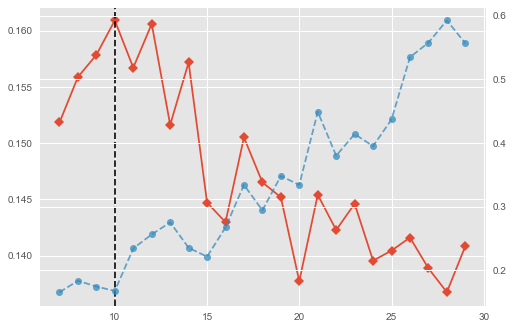

In [40]:
# We'll start with k-means++ initialization method (default method)
model = KMeans(
    init='random',
    algorithm='elkan',
)

model.n_clusters = calculate_silhouette(model, df_movies)

d = {
    'Initialization' : model.init,
    'K-approximation method' : 'silhouette',
    'Number of clusters' : model.n_clusters
}

results = {**d, **benchmark_k_means(model, df_movies) } # Merges the 2 dictionaries.

df_kmeans_movies = df_kmeans_movies.append(results, ignore_index=True)

In [41]:
df_kmeans_movies

,Initialization,K-approximation method,Number of clusters,Inertia,Silhouette score,Fit time
0,k-means++,elbow,9,25783.626909,0.104845,0.255316
1,k-means++,silhouette,9,25784.864276,0.103837,0.229433
2,random,elbow,9,25864.199625,0.099874,0.327126
3,random,silhouette,10,24856.799937,0.115895,0.233343


### DBSCAN

For this benckmark, different combinations of epsilon and min_samples are used for the measurement of the Silhouette score.

In [211]:
arr_eps = []
arr_sam = []
arr_sil = []

min_eps = 0.3
max_eps = 1

min_samples = 5
max_samples = 100

total_samples = 0
# Initial loop.
try:
    for eps in np.arange(min_eps, max_eps, 0.1):            # arrange used for float steps
        for sam in range(min_samples, max_samples, min_samples):
            model = DBSCAN(eps=eps, min_samples=sam)
            l  = model.fit_predict(df_movies)
            sil = metrics.silhouette_score(df_movies, l)

            arr_eps.append(eps)
            arr_sam.append(sam)
            arr_sil.append(sil)
except:
    print(f"Error with values: eps: {eps}, sam: {sam}.")

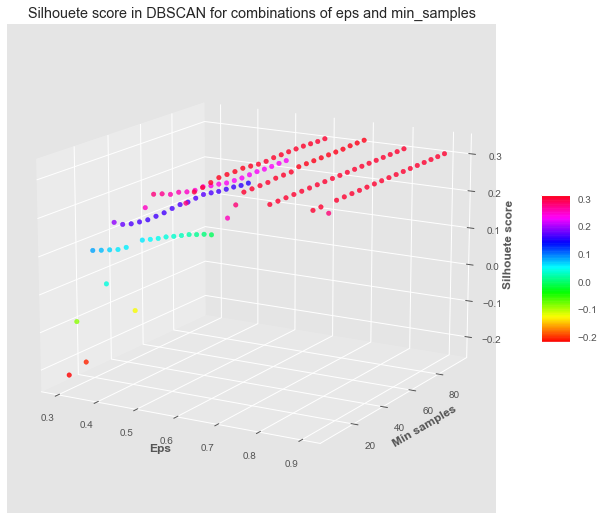

In [225]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

z = arr_sil
x = arr_eps
y = arr_sam
 
# Creating figure
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
   
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
 
 
# Creating color map
my_cmap = plt.get_cmap('hsv')
 
# Creating plot
sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = z,
                    cmap = my_cmap,
                    marker ='o')
ax.view_init(15)
 
plt.title("Silhouete score in DBSCAN for combinations of eps and min_samples")
ax.set_xlabel('Eps', fontweight ='bold')
ax.set_ylabel('Min samples', fontweight ='bold')
ax.set_zlabel('Silhouete score', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.3, aspect = 5)
 
# show plot
plt.show()

The graphic showcases the fact that epsilon value is the most relevant when it comes to the quality of the cluster, while the number of samples in a neighborhood for a point to be considered as a core point is not so important for the final outcome.

In [213]:
best_config = {
    'eps': arr_eps[np.argmax(arr_sil)],
    'sam': arr_sam[np.argmax(arr_sil)]
}

In [214]:
best_config

{'eps': 0.7000000000000002, 'sam': 85}

# Collaborative filtering approach

The collaborative approach (or collaborative filtering approach) may
consider a user’s social environment. It recommends items based on the opinions of
other customers who have similar tastes or preferences as the user.

In [7]:
df_ratings = pd.read_json('Data/datasets/final/ratings_reduced_25.json', orient='records')

In [8]:
df_ratings_normal = df_ratings.sample(frac=0.015)

We'll study the effect that pivoting the data may have in the quality of the resulting cluster.

In [9]:
df_ratings_pivoted = df_ratings_normal.pivot(
    columns='userId',
    index='movieId',
    values='rating'
    )

In [10]:
df_ratings_pivoted.shape

(1217, 8446)

In [11]:
df_ratings_pivoted.head(2)

userId,3,31,75,97,143,155,158,181,187,201,...,162445,162457,162476,162481,162486,162495,162499,162516,162519,162524
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_ratings_pivoted.isnull().sum().sum()

10269494

In [13]:
df_ratings_pivoted = df_ratings_pivoted.fillna(0)

## KMeans

Data for the pivoted dataframe is extremely sparse. To try to overcome it, we'll try two different methods.

### CRS matrix

The compressed sparse row represents a matrix M by three (one-dimensional) arrays, that respectively contain nonzero values, the extents of rows, and column indices.

In [121]:
df_ratings_crs = csr_matrix(df_ratings_pivoted)

In [122]:
df_ratings_pivoted.reset_index(inplace=True)

In [126]:
knn = KMeans()

In [128]:
knn.fit(df_ratings_crs)

KMeans()

### SDV -- Singular value decomposition

SDV is similar to Principal component analysis (PCA). It's more suitable for sparse data as it does not center the data before computing the singular value decomposition.

In [182]:
svd = TruncatedSVD(n_components=100)

In [141]:
a = svd.fit_transform(df_ratings_pivoted)

C:\Users\Iñigo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [158]:
knn = KMeans()

knn.fit_transform(a)

array([[133363.88264028,   3570.93060688,  79074.7915112 , ...,
         32619.98636918,  54973.50184166, 160822.96180884],
       [133358.8699496 ,   3565.69004399,  79069.77226326, ...,
         32614.94605201,  54968.47601942, 160817.95098566],
       [133356.85825784,   3563.4743731 ,  79067.75465827, ...,
         32612.90941166,  54966.45251655, 160815.9409982 ],
       ...,
       [ 66945.97131472, 196755.11584546, 121236.37686878, ...,
        167694.80998819, 145338.77691732,  39486.36795214],
       [ 68285.971268  , 198095.10736517, 122576.37581333, ...,
        169034.80772715, 146678.77519812,  40826.36799901],
       [ 68412.97265654, 198222.11052409, 122703.37770895, ...,
        169161.80998112, 146805.7773083 ,  40953.36931175]])

## Benchmarking

In [17]:
# Define dataframe:
df_bench_ratings = pd.DataFrame(
    columns = [
        'Initialization',           # K-means++ or random.
        'Dim. red. method',         # Dimensionality reduction method. Either CRS or SDV.
        'K-approximation method',   # Elbow or silhouette.
        'Number of clusters',       # Number of clusters suggested by the approximation method.
        'Inertia',                  # Or within-cluster sum-of-squares. The lower, the better.
    ]
)

In [18]:
import warnings
warnings.filterwarnings("ignore")

# Function to obtain K approximation.

def calculate_elbow(model, data):
    visualizer = KElbowVisualizer(
        model,
        k=(2,30),                   # k is range of number of clusters.
        timings=True
    )

    visualizer.fit(data)            # Fit the data to the visualizer

    return visualizer.elbow_value_

def calculate_silhouette(model, data):
    visualizer = KElbowVisualizer(
        model,
        k=(7,30),                   # k is range of number of clusters.
        metric = 'silhouette',      # 2nd method to approximate K.
        timings=True
    )

    visualizer.fit(data)            # Fit the data to the visualizer

    return visualizer.elbow_value_

### CRS

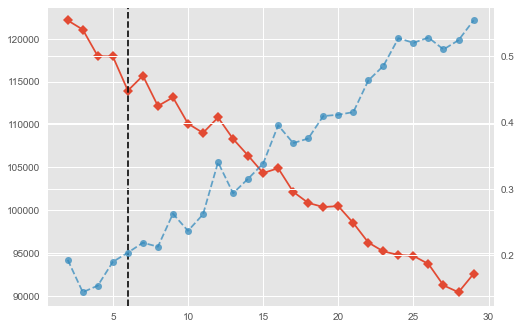

In [19]:
# We'll start with k-means++ initialization method (default method)
model = KMeans(
    init='k-means++',
    algorithm='elkan'
)

data = csr_matrix(df_ratings_pivoted)

model.n_clusters = calculate_elbow(model, data)

model.fit_transform(data)

d = {
    'Initialization' : model.init,
    'Dim. red. method' : 'CRS',
    'K-approximation method' : 'elbow',
    'Number of clusters' : model.n_clusters,
    'Inertia' : model.inertia_
}

df_bench_ratings = df_bench_ratings.append(d, ignore_index=True)

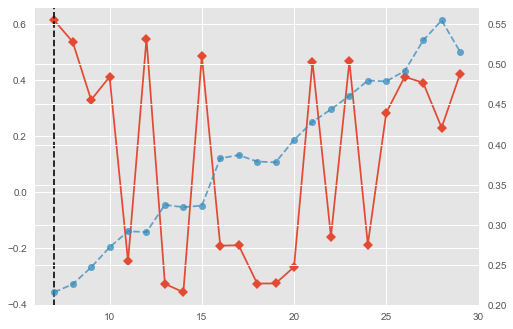

In [20]:
# We'll start with k-means++ initialization method (default method)
model = KMeans(
    init='k-means++',
    algorithm='elkan'
)

data = csr_matrix(df_ratings_pivoted)

model.n_clusters = calculate_silhouette(model, data)

model.fit_transform(data)

d = {
    'Initialization' : model.init,
    'Dim. red. method' : 'CRS',
    'K-approximation method' : 'silhouette',
    'Number of clusters' : model.n_clusters,
    'Inertia' : model.inertia_
}

df_bench_ratings = df_bench_ratings.append(d, ignore_index=True)

### SDV

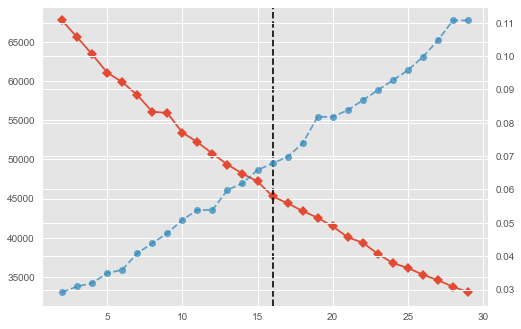

In [21]:
# We'll start with k-means++ initialization method (default method)
model = KMeans(
    init='k-means++',
    algorithm='elkan'
)

#crs  = csr_matrix(df_ratings_pivoted)
svd  = TruncatedSVD(n_components=100)
data = svd.fit_transform(df_ratings_pivoted)

model.n_clusters = calculate_elbow(model, data)

model.fit_transform(data)

d = {
    'Initialization' : model.init,
    'Dim. red. method' : 'SDV',
    'K-approximation method' : 'elbow',
    'Number of clusters' : model.n_clusters,
    'Inertia' : model.inertia_
}

df_bench_ratings = df_bench_ratings.append(d, ignore_index=True)

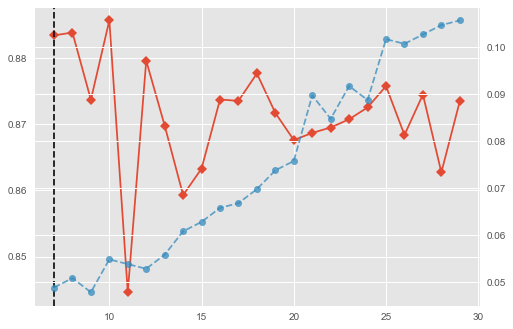

In [22]:
# We'll start with k-means++ initialization method (default method)
model = KMeans(
    init='k-means++',
    algorithm='elkan'
)

#crs  = csr_matrix(df_ratings_pivoted)
svd  = TruncatedSVD(n_components=100)
data = svd.fit_transform(df_ratings_pivoted)

model.n_clusters = calculate_silhouette(model, data)

model.fit_transform(data)

d = {
    'Initialization' : model.init,
    'Dim. red. method' : 'SDV',
    'K-approximation method' : 'silhouette',
    'Number of clusters' : model.n_clusters,
    'Inertia' : model.inertia_
}

df_bench_ratings = df_bench_ratings.append(d, ignore_index=True)

In [23]:
df_bench_ratings

,Initialization,Dim. red. method,K-approximation method,Number of clusters,Inertia
0,k-means++,CRS,elbow,6,117404.867987
1,k-means++,CRS,silhouette,7,115811.132535
2,k-means++,SDV,elbow,16,45513.484927
3,k-means++,SDV,silhouette,7,59221.175261


### SDV with different dimensionality.

The superiority of the silhouette method is clear. Now, let's try to obtain the best possible value for SDV. We'll test different values for n_components and check if the change in dimensionality has any effect in the quality of the clusters.


In [31]:
# Define dataframe:
df_bench_sdv = pd.DataFrame(
    columns = [
        'Initialization',           # K-means++ or random.
        'Dimensionality',           # Dimensionality of output data
        'K-approximation method',
        'Number of clusters',       # Number of clusters suggested by the approximation method.
        'Inertia',                  # Or within-cluster sum-of-squares. The lower, the better.
    ]
)

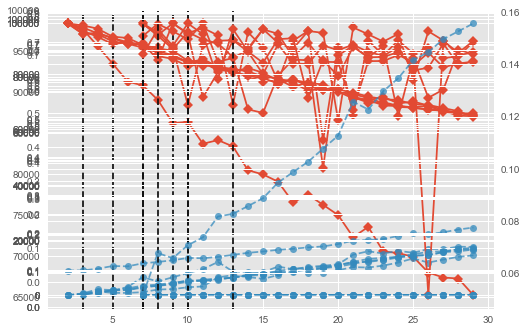

In [32]:
# We'll start with k-means++ initialization method (default method)
model = KMeans(
    init='k-means++',
    algorithm='elkan'
)


for i in range(50, 350, 50): # [50,300]
    # Elbow approximation
    data = svd.fit_transform(df_ratings_pivoted)

    model.n_clusters = calculate_elbow(model, data) # We calculate each time the number of clusters in case it may change.

    model.fit_transform(data)

    d = {
        'Initialization' : model.init,
        'Dimensionality' : i,
        'K-approximation method' : 'elbow',
        'Number of clusters' : model.n_clusters,
        'Inertia' : model.inertia_
    }

    df_bench_sdv = df_bench_sdv.append(d, ignore_index=True)

    # Silhouette approximation
    data = svd.fit_transform(df_ratings_pivoted)

    model.n_clusters = calculate_silhouette(model, data) # We calculate each time the number of clusters in case it may change.

    model.fit_transform(data)

    d = {
        'Initialization' : model.init,
        'Dimensionality' : i,
        'K-approximation method' : 'silhouette',
        'Number of clusters' : model.n_clusters,
        'Inertia' : model.inertia_
    }

    df_bench_sdv = df_bench_sdv.append(d, ignore_index=True)
    

In [33]:
df_bench_sdv.sort_values(by=['Inertia'])

,Initialization,Dimensionality,K-approximation method,Number of clusters,Inertia
10,k-means++,300,elbow,13,82435.265326
8,k-means++,250,elbow,10,85227.798425
6,k-means++,200,elbow,10,85964.966327
0,k-means++,50,elbow,9,86390.818990
11,k-means++,300,silhouette,8,88493.576692
5,k-means++,150,silhouette,7,90297.858686
1,k-means++,50,silhouette,7,90545.321007
9,k-means++,250,silhouette,7,90646.804360
3,k-means++,100,silhouette,7,91689.422421
7,k-means++,200,silhouette,7,92043.651860


We can obser a downward tren in the inertia as the dimensionality is reduced, this can be due to the fact that inertia is the sum of squared distances of samples to their closest cluster center. With an increase in dimensions, the curse of curse of dimensionality takes place. Let's try smaller dimensions.

---

# Hybrid approach

Combines both content-based and collaborative methods.

After benchmarking the different clustering methods, we'll get the best rating ones and get recommendations from both. Afterwards, we'll mix the content-based approach and the collaborative approach for a hybrid one.

## Content-based recommendations.

In [ ]:
def label_encoder(x, encoder):
    return encoder.transform([x])[0]

def label_decoder(x, encoder):
    return encoder.inverse_transform(x)

def scale(x, scaler):
    return scaler.transform(x)

def scale_inverse(x, scaler):
    return scaler.inverse_transform(x)



def get_recommendation_content(movie_name, model, encoder, data, number_of_recommendations = 5):
    """
    Function that returns a recommendation based on another movie.

    Parameters
    ----------
    movie_name

    model : cluster model used

    encoder : encoder previously used to encode data

    scaler : scaler previously used to encode data

    data : full dataset

    number_of_recommendations

    Returns
    -------
    recommended_film
    """
    # Get movie 

    # Encode and scale movie name.

    # Get N closes elements to 